## MNIST AutoEncoder Experiment

### **Objective**
This notebook demonstrates how to train an AutoEncoder on the MNIST dataset using two different loss functions:
1. **Mean Squared Error (MSE)** - A standard reconstruction loss that ensures input images are faithfully reconstructed.
2. **Triplet Loss** - A contrastive learning objective that structures the latent space to separate classes effectively.

### **Workflow Overview**
The notebook follows these key steps:
- **Step 1**: Load and preprocess the MNIST dataset.
- **Step 2**: Define training functions for MSE and Triplet Loss.
- **Step 3**: Implement custom batching functions to prepare data for triplet loss.
- **Step 4**: Train an AutoEncoder using both loss functions.
- **Step 5**: Visualize and compare latent space embeddings using t-SNE.

By the end, we will have insights into how different loss functions affect the learned representations.


In [1]:
import logging
import os

import hydra
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import tensorflow_datasets as tfds
import wandb
from flax.training.early_stopping import EarlyStopping
from flax.training.train_state import TrainState
from omegaconf import DictConfig, OmegaConf
from sklearn.decomposition import PCA

from ae_utils.ae import AutoEncoder
from ae_utils.losses import triplet_loss_fn

/tmp/.config/matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /tmp/matplotlib-63rqbo_m because there was an issue with the default path (/tmp/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/tmp/matplotlib-63rqbo_m is not a writable directory
Matplotlib created a temporary cache directory at /tmp/matplotlib-i8e5uiq5 because there was an issue with the default path (/tmp/matplotlib-63rqbo_m); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Step 1: Load the MNIST dataset

In [2]:
def get_datasets():
    """Load MNIST dataset and return dataset info."""
    data_dir = os.path.join("..", "mnist_exp/data")
    print(f"Data directory: {data_dir}")
    mnist_data, info = tfds.load(
        "mnist", batch_size=-1, data_dir=data_dir, with_info=True, shuffle_files=True
    )
    mnist_data = tfds.as_numpy(mnist_data)
    train_data, test_data = mnist_data["train"], mnist_data["test"]
    num_labels = info.features["label"].num_classes
    h, w, c = info.features["image"].shape

    info = {
        "num_labels": num_labels,
        "img_shape": (h, w, c),
    }

    train_images, train_labels = train_data["image"], train_data["label"]
    test_images, test_labels = test_data["image"], test_data["label"]

    def normalize_img(image):
        return jnp.float32(image) / 255.0

    train_images = normalize_img(train_images)
    test_images = normalize_img(test_images)

    return train_images, train_labels, test_images, test_labels, info

### Step 2: Define the Training Functions

We define separate training functions for:
- **MSE Loss Training**: Trains the AutoEncoder to reconstruct images.
- **Triplet Loss Training**: Trains the AutoEncoder to cluster images of the same digits together.

**Reconstruction Loss:** The network minimizes pixel-wise differences between input and reconstructed images.
**Contrastive Loss:** Each sample is associated with a positive (same class) and a negative (different class) to enforce meaningful clustering in latent space.



In [3]:
def train_step_mse(state: TrainState, batch_imgs):
    """Training step for MSE loss."""

    def compute_loss(params):
        recon_imgs, _ = state.apply_fn({"params": params}, batch_imgs)
        loss = ((recon_imgs - batch_imgs) ** 2).mean()
        return loss, {"recon_loss": loss, "model_loss": loss}

    (loss, metrics), grads = jax.value_and_grad(compute_loss, has_aux=True)(
        state.params
    )
    state = state.apply_gradients(grads=grads)
    return state, loss, metrics

In [4]:
def train_step_triplet(state: TrainState, batch: jnp.ndarray, alpha: float):
    """Training step for triplet loss."""
    anchor = batch[:, 0]
    positive = batch[:, 1]
    negative = batch[:, 2]

    def compute_loss(params):
        _, anchor_latent = state.apply_fn(
            {"params": params},
            anchor,
        )
        _, pos_latent = state.apply_fn(
            {"params": params},
            positive,
        )
        _, neg_latent = state.apply_fn(
            {"params": params},
            negative,
        )

        triplet_loss = jax.vmap(triplet_loss_fn, in_axes=(0, 0, 0, None))(
            anchor_latent, pos_latent, neg_latent, alpha
        )
        triplet_loss = jnp.mean(triplet_loss)

        # Also compute reconstruction loss for monitoring
        recon_anchor, _ = state.apply_fn({"params": params}, anchor)
        recon_loss = ((recon_anchor - anchor) ** 2).mean()

        return triplet_loss, {
            "triplet_loss": triplet_loss,
            "recon_loss": recon_loss,
            "model_loss": triplet_loss,
        }

    (loss, metrics), grads = jax.value_and_grad(compute_loss, has_aux=True)(
        state.params
    )
    state = state.apply_gradients(grads=grads)
    return state, loss, metrics

### Step 3: Define Custom Batching Functions for Creating Triplets

The following functions handle the creation of batches for training the AutoEncoder on the MNIST dataset.
We use two types of batching:
1. **Standard Batching**: Groups images into batches for training with Mean Squared Error (MSE) loss.
2. **Triplet Batching**: Creates triplet samples for training with Triplet Loss to enforce similarity constraints in the latent space.

In [5]:
def get_batches(images, labels, batch_size, key):
    """
    Create shuffled batches from images and labels.

    Standard batching method that groups MNIST images into batches of size `batch_size`. 
    This is useful when training an AutoEncoder using the Mean Squared Error (MSE) loss.

    Args:
        images (jnp.ndarray): The dataset of images.
        labels (jnp.ndarray): The corresponding labels for the images.
        batch_size (int): Number of images per batch.
        key (jax.random.PRNGKey): A random key for shuffling.

    Returns:
        image_batches (jnp.ndarray): Batched images.
        label_batches (jnp.ndarray): Batched labels.
        num_batches (int): Total number of batches.
    """
    num_samples = len(images)
    num_batches = num_samples // batch_size

    # Shuffle indices
    shuffled_idx = jax.random.permutation(key, jnp.arange(num_samples))

    # Truncate to multiple of batch_size
    truncated_idx = shuffled_idx[: num_batches * batch_size]

    # Reshape into batches
    batch_idx = truncated_idx.reshape((num_batches, batch_size))

    # Create batches using fancy indexing
    image_batches = images[batch_idx]
    label_batches = labels[batch_idx]

    return image_batches, label_batches, num_batches

In [6]:
def get_triplet_batches(images, labels, batch_size, key):
    """
    Create triplet batches for training with Triplet Loss.

    Triplet loss is used to train embeddings that enforce similarity constraints:
    - Each batch consists of anchor, positive, and negative samples.
    - The positive sample belongs to the same class as the anchor.
    - The negative sample belongs to a different class.

    Args:
        images (jnp.ndarray): The dataset of images.
        labels (jnp.ndarray): The corresponding labels for the images.
        batch_size (int): Number of triplets per batch.
        key (jax.random.PRNGKey): A random key for shuffling.

    Returns:
        triplet_batches (jnp.ndarray): Batched triplets (anchor, positive, negative).
        num_batches (int): Total number of batches.
    """
    # First get regular batches
    image_batches, label_batches, num_batches = get_batches(
        images, labels, batch_size, key
    )

    triplet_batches = []
    # Create triplets for each batch
    for batch_idx in range(num_batches):
        batch_images = image_batches[batch_idx]
        batch_labels = label_batches[batch_idx]

        key, subkey = jax.random.split(key)
        triplet_batch = get_triplets(batch_images, batch_labels, subkey)
        triplet_batches.append(triplet_batch)

    return jnp.stack(triplet_batches), num_batches


def get_triplets(images, labels, key):
    """
    Generate triplets for Triplet Loss training.

    A triplet consists of:
    - An anchor sample.
    - A positive sample (same class as the anchor).
    - A negative sample (different class than the anchor).

    The function selects these triplets efficiently in a vectorized manner.

    Args:
        images (jnp.ndarray): The dataset of images.
        labels (jnp.ndarray): The corresponding labels for the images.
        key (jax.random.PRNGKey): A random key for randomness in sampling.

    Returns:
        triplets (jnp.ndarray): A batch of triplets.
    """
    n_samples = len(labels)

    # Create matrix of all pairs of label comparisons
    label_matches = labels[:, None] == labels[None, :]
    label_mismatches = ~label_matches

    # Mask out self-comparisons for positive pairs
    positive_mask = label_matches & ~jnp.eye(n_samples, dtype=bool)

    random_key, key1, key2 = jax.random.split(key, 3)

    def choose_masked_indices(mask, key):
        # Create random probabilities for each position
        probs = jax.random.uniform(key, (n_samples, n_samples))
        # Set probability to -1 for invalid positions (will never be selected)
        masked_probs = jnp.where(mask, probs, -1.0)
        # Take argmax along axis 1 to select one index per row
        return jnp.argmax(masked_probs, axis=1)

    # Choose positive and negative samples
    pos_indices = choose_masked_indices(positive_mask, key1)
    neg_indices = choose_masked_indices(label_mismatches, key2)

    # Gather the images
    anchor_images = images
    positive_images = images[pos_indices]
    negative_images = images[neg_indices]

    # Stack the triplets
    triplets = jnp.stack([anchor_images, positive_images, negative_images], axis=1)

    return triplets

### Step 4: Training the AutoEncoder

We will compare two models trained with the two different objectives and later visualize the resulting latent projections of our test data.

We define the hyperparameters for our training loop below. 

In [7]:
hidden_size = 2 # AE latent dims
features = 16 # AE hidden layer size

learning_rate = 1e-2 # learning rate
model_epoch_period = 10 # number of training epochs
model_batch_size = 128 # training batch size

triplet_margin = 0.2 # triplet loss margin

In [8]:
# Load dataset
train_images, train_labels, test_images, test_labels, info = get_datasets()
# Use only a subset of training data
random_key = jax.random.PRNGKey(0)
# Shuffle and select subset
random_key, subkey = jax.random.split(random_key)
perm = jax.random.permutation(subkey, len(train_images))
train_images, train_labels = train_images[perm], train_labels[perm]
train_images, train_labels = train_images[:10000], train_labels[:10000]
print(f"Train images: {train_images.shape}, Test images: {test_images.shape}")
print(f"Image shape: {info['img_shape']}")

# Initialize model
model_mse = AutoEncoder(
    img_shape=info["img_shape"],
    latent_size=hidden_size,
    features=features,
        )
model_triplet = AutoEncoder(
    img_shape=info["img_shape"],
    latent_size=hidden_size,
    features=features,
        )

# Initialize training state
random_key, subkey = jax.random.split(random_key)
dummy_input = jnp.ones((1, *info["img_shape"]))
params_mse = model_mse.init(subkey, dummy_input)["params"]
params_triplet = model_triplet.init(subkey, dummy_input)["params"]

optimizer_mse = optax.adam(learning_rate)
state_mse = TrainState.create(apply_fn=model_mse.apply, params=params_mse, tx=optimizer_mse)

optimizer_triplet = optax.adam(learning_rate)
state_triplet = TrainState.create(apply_fn=model_triplet.apply, params=params_triplet, tx=optimizer_triplet)

Data directory: ../mnist_exp/data


2025-03-20 15:03:39.458894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742483019.475614    5247 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742483019.480820    5247 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1742483021.135234    5247 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10274 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Train images: (10000, 28, 28, 1), Test images: (10000, 28, 28, 1)
Image shape: (28, 28, 1)


In [9]:
# Training loop for mse loss
print("Training AutoEncoder with Reconstruction Objective...")
for epoch in range(model_epoch_period):
    epoch_loss = 0
    batch_metrics = []

    random_key, subkey = jax.random.split(random_key)
    batches, _, num_batches = get_batches(
        train_images, train_labels, model_batch_size, subkey
    )

    for batch_idx in range(num_batches):
        batch = batches[batch_idx]
        state_mse, loss, metrics = jax.jit(train_step_mse)(state_mse, batch)

        epoch_loss += loss
        batch_metrics.append(metrics)

    avg_loss = epoch_loss / num_batches
    avg_metrics = jax.tree.map(
        lambda *xs: jnp.mean(jnp.stack(xs)), *batch_metrics
    )
    print(f"Epoch {epoch} - Loss: {avg_loss}")


Training AutoEncoder with Reconstruction Objective...
Epoch 0 - Loss: 0.07082870602607727
Epoch 1 - Loss: 0.05639761686325073
Epoch 2 - Loss: 0.05347202345728874
Epoch 3 - Loss: 0.05181017890572548
Epoch 4 - Loss: 0.05070619285106659
Epoch 5 - Loss: 0.049726586788892746
Epoch 6 - Loss: 0.04892518371343613
Epoch 7 - Loss: 0.04822513088583946
Epoch 8 - Loss: 0.0478387288749218
Epoch 9 - Loss: 0.04750003665685654


In [10]:
# Training loop for triplet loss
print("Training AutoEncoder with Contrastive Learning Objective...")
for epoch in range(model_epoch_period):
    epoch_loss = 0
    batch_metrics = []

    random_key, subkey = jax.random.split(random_key)
    batches, num_batches = get_triplet_batches(
            train_images, train_labels, model_batch_size, subkey
        )

    for batch_idx in range(num_batches):
        batch = batches[batch_idx]
        state_triplet, loss, metrics = jax.jit(train_step_triplet)(
            state_triplet, batch, triplet_margin
        )

        epoch_loss += loss
        batch_metrics.append(metrics)

    avg_loss = epoch_loss / num_batches
    avg_metrics = jax.tree.map(
        lambda *xs: jnp.mean(jnp.stack(xs)), *batch_metrics
    )
    print(f"Epoch {epoch} - Loss: {avg_loss}")

Training AutoEncoder with Contrastive Learning Objective...
Epoch 0 - Loss: 0.10918951034545898
Epoch 1 - Loss: 0.06778109818696976
Epoch 2 - Loss: 0.0578317828476429
Epoch 3 - Loss: 0.05522419139742851
Epoch 4 - Loss: 0.05448390915989876
Epoch 5 - Loss: 0.046029265969991684
Epoch 6 - Loss: 0.044471774250268936
Epoch 7 - Loss: 0.04247117415070534
Epoch 8 - Loss: 0.03918813541531563
Epoch 9 - Loss: 0.040828887373209


### Step 5: Visualizing the Latent Spaces

To understand how different loss functions affect learned representations, we compare:
- **MSE-trained embeddings** (expected to have overlapping digit clusters).
- **Triplet-trained embeddings** (expected to have well-separated digit clusters).

In [11]:
def plot_latent_space_digits(model, params, images, labels, fig_title="Latent Space Visualization"):
    """Plot latent space embeddings showing digit images colored by class."""
    # Get embeddings
    embeddings = model.apply({"params": params}, images, method=model.encode)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Set plot limits with some margins
    x_min, x_max = embeddings[:, 0].min(), embeddings[:, 0].max()
    y_min, y_max = embeddings[:, 1].min(), embeddings[:, 1].max()
    margin = 0.1
    ax.set_xlim(x_min - margin, x_max + margin)
    ax.set_ylim(y_min - margin, y_max + margin)

    # Calculate image size based on data range
    x_range = x_max - x_min
    y_range = y_max - y_min
    img_size = min(x_range, y_range) * 0.04

    # Colors for different classes
    colors = plt.cm.tab10(np.linspace(0, 1, 10))

    for i in range(10):
        mask = labels == i
        if np.any(mask):
            ax.scatter(
                embeddings[mask, 0],
                embeddings[mask, 1],
                c=[colors[i]],
                alpha=0.3,
                s=10
            )

    # Plot each digit as a small image
    for img, embedding, label in zip(images, embeddings, labels):
        # Calculate position in data coordinates
        x, y = embedding[0], embedding[1]
        
        # Create inset axes using data coordinates
        ax_inset = ax.inset_axes(
            [x-img_size/2, y-img_size/2, img_size, img_size],
            transform=ax.transData
        )

        # Reshape image and create RGBA array
        digit_img = img.reshape(28, 28)
        
        # Create RGBA array with transparency
        rgba_img = np.zeros((28, 28, 4))
        # Set RGB channels to the class color where digit is present
        for c in range(3):
            rgba_img[:, :, c] = colors[label][c] * (digit_img > 0.5)
        # Set alpha channel - make digit opaque and background transparent
        rgba_img[:, :, 3] = (digit_img > 0.5).astype(float)

        # Plot the digit image
        ax_inset.imshow(rgba_img, interpolation='bilinear')
        
        # Remove ticks and spines from inset axes
        ax_inset.set_xticks([])
        ax_inset.set_yticks([])
        for spine in ax_inset.spines.values():
            spine.set_visible(False)

    # Set main axes properties and limits
    plt.title(fig_title)
    plt.xlabel("First Component")
    plt.ylabel("Second Component")
    ax.set_xticks([])
    ax.set_yticks([])

    # Create custom legend
    legend_elements = [
        plt.Line2D([0], [0], color=colors[i], label=f"Digit {i}", linewidth=2)
        for i in range(10)
    ]
    plt.legend(
        handles=legend_elements,
        title="Digit Classes",
    )

    return fig

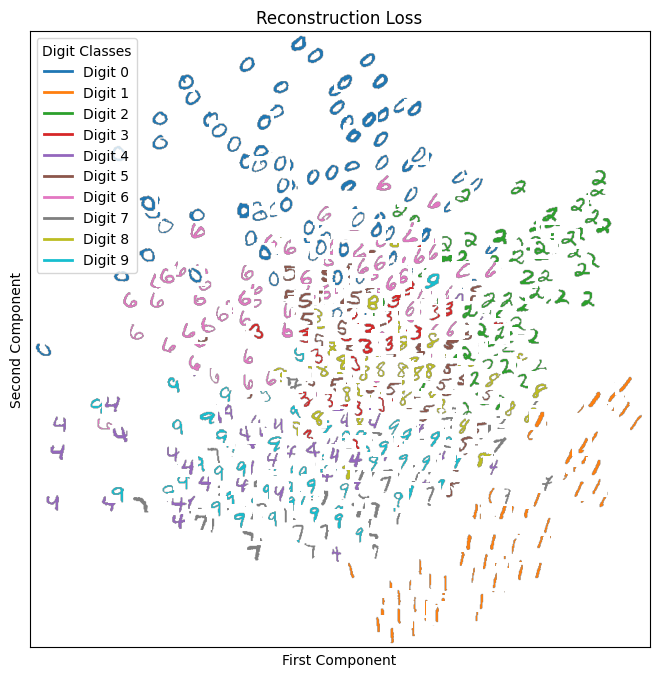

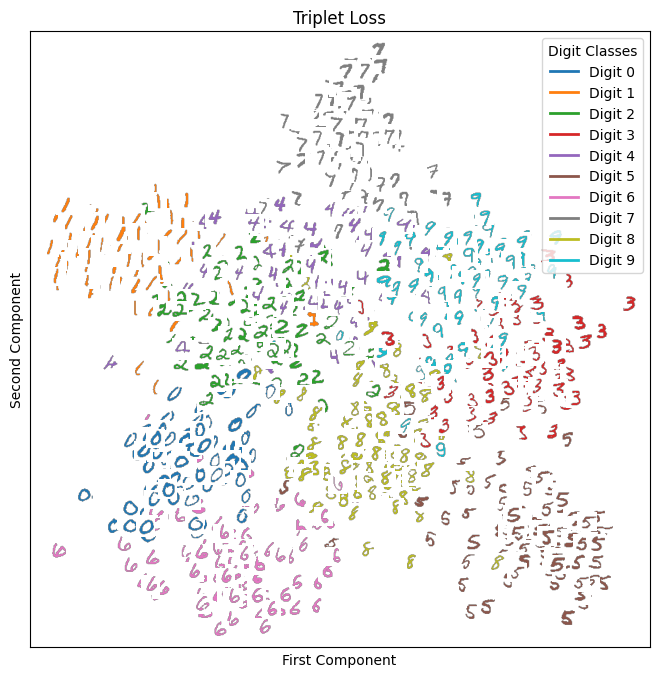

In [14]:
random_key, subkey = jax.random.split(random_key)
perm = jax.random.permutation(subkey, len(test_images))
test_images, test_labels = test_images[perm], test_labels[perm]
test_images, test_labels = test_images[:1000], test_labels[:1000]

latent_fig = plot_latent_space_digits(
    model_mse, state_mse.params, test_images, test_labels, fig_title="Reconstruction Loss"
)
latent_fig = plot_latent_space_digits(
    model_triplet, state_triplet.params, test_images, test_labels, fig_title="Triplet Loss"
)